In [1]:
!pip install yfinance
!pip install numpy

import math
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco


In [2]:
stocks=['AAPL','TSLA','NVDA','GOOGL','AMZN','INTC','XOM']

eD=dt.datetime.today()
sD=eD-dt.timedelta(2*365)

price=yf.download(stocks,
                  period = '2y')['Adj Close'].pct_change()
returns=price
al=len(stocks)

[*********************100%%**********************]  7 of 7 completed


In [3]:
class Tools:
    def __init__(self,returns, assets):
        self.returns = returns
        self.assets = assets
 
    def simpleComp(self):
        self.tbl=pd.DataFrame(index=self.assets)
        self.tbl['Mean']=returns.mean()
        self.tbl['Variance']=returns.var()
        return(self.tbl.T)
   
    def correlation(self):
        self.tbl=pd.DataFrame(index=self.assets)
        self.corr=returns.corr()
        return(self.corr)
    

In [4]:
tls=Tools(returns=returns, assets=stocks)

display(tls.simpleComp().T,tls.correlation())


,Mean,Variance
AAPL,0.000493,0.000352
TSLA,-0.000507,0.001535
NVDA,0.001619,0.001379
GOOGL,-0.000039,0.000479
AMZN,-0.000015,0.000727
INTC,-0.000167,0.000564
XOM,0.001315,0.000377


,AAPL,AMZN,GOOGL,INTC,NVDA,TSLA,XOM
AAPL,1.000000,0.618171,0.703431,0.564447,0.654021,0.577723,0.225970
AMZN,0.618171,1.000000,0.686954,0.467547,0.599701,0.496334,0.148798
GOOGL,0.703431,0.686954,1.000000,0.524024,0.635663,0.464871,0.137560
INTC,0.564447,0.467547,0.524024,1.000000,0.521792,0.386955,0.204433
NVDA,0.654021,0.599701,0.635663,0.521792,1.000000,0.568654,0.126020
TSLA,0.577723,0.496334,0.464871,0.386955,0.568654,1.000000,0.089987
XOM,0.225970,0.148798,0.137560,0.204433,0.126020,0.089987,1.000000


In [5]:
def pR(w):
    return np.sum(returns.mean() * w) * 252
#portfolio volumes
def pV(w):
    return np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252,w)))

retCol = []
volCol = []
wei =[]

for p in range (400000):
    
    weights = np.random.random(al)
    weights /= np.sum(weights)
    
    wei.append(weights)
    
    retCol.append(pR(weights))
    volCol.append(pV(weights))

ER = np.array(retCol)
EV = np.array(volCol)

sharpe=(ER-0.02)/EV

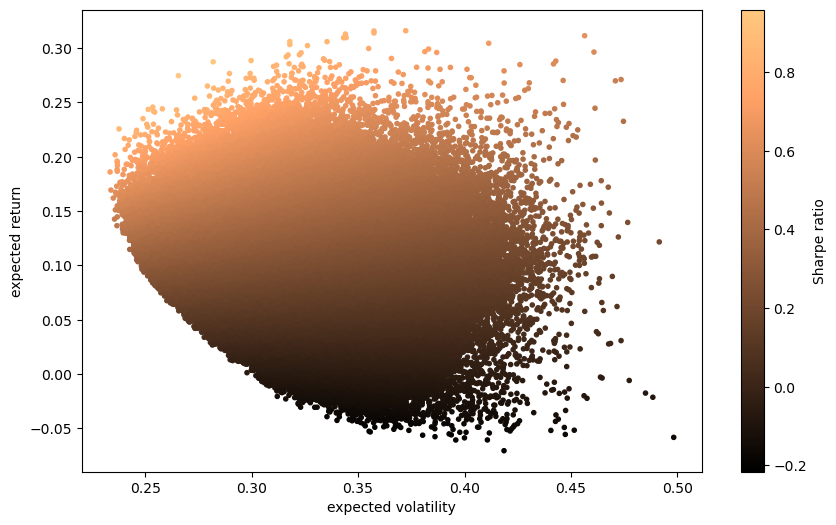

In [9]:
plt.figure(figsize=(10,6 ))
plt.scatter(EV, ER, c=sharpe,
marker='.', cmap='copper')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

In [10]:
tbl2=pd.DataFrame(columns=['Expected Return',
                           'Volatility',
                           'Optimal Sharpe Ratio'])
tbl2['Expected Return']=ER
tbl2['Volatility']=EV
tbl2['Optimal Sharpe Ratio']=sharpe

for counter, symbol in enumerate(returns.columns.tolist()):
    tbl2[symbol + "'s weight"] = [w[counter] for w in wei]


tbl2.set_index("Optimal Sharpe Ratio", inplace=True)
portfolios = pd.DataFrame(tbl2)
tbl2F=portfolios.head().T
tbl2F

Optimal Sharpe Ratio,0.287052,0.139340,0.589226,0.197241,0.163496
Expected Return,0.105138,0.067573,0.201239,0.083725,0.070384
Volatility,0.296595,0.341420,0.307589,0.323083,0.308167
AAPL's weight,0.219150,0.179721,0.070775,0.155634,0.042304
AMZN's weight,0.017553,0.027973,0.043910,0.114203,0.207545
GOOGL's weight,0.159987,0.177667,0.089368,0.066684,0.133137
INTC's weight,0.140649,0.240661,0.171366,0.097295,0.172008
NVDA's weight,0.109447,0.169459,0.276860,0.089824,0.085438
TSLA's weight,0.166100,0.173615,0.059918,0.272142,0.173255
XOM's weight,0.187115,0.030903,0.287803,0.204218,0.186312


In [11]:
def sharpeMinzd(w):
    return -(pR(w)-.02) / pV(w)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(al))
eWV = np.array(al * [1. / al,])

sharpeMinzd(eWV)      

-0.24588066808347342

In [12]:
sharpeOptimized=sco.minimize(sharpeMinzd,
                             eWV,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)
volOptimized=sco.minimize(pV,
                             eWV,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

cons = ({'type': 'eq', 'fun': lambda x: pR(x) - treturn},
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

treturns = np.linspace(0.05, 0.2, 50)
tvolatility = []

for treturn in treturns:
    res = sco.minimize(pV, eWV, method='SLSQP',
                       bounds=bnds, 
                       constraints=cons)
    tvolatility.append(res['fun'])
tvolatility = np.array(tvolatility)

In [13]:
OPR=pR(sharpeOptimized['x'])
OPR.round(4)

0.3491

In [14]:
OPVW=pV(sharpeOptimized['x'])
OPVW.round(4)

0.288

In [15]:
SRM=(OPR-0.02)/OPVW
SRM.round(4)

1.1429

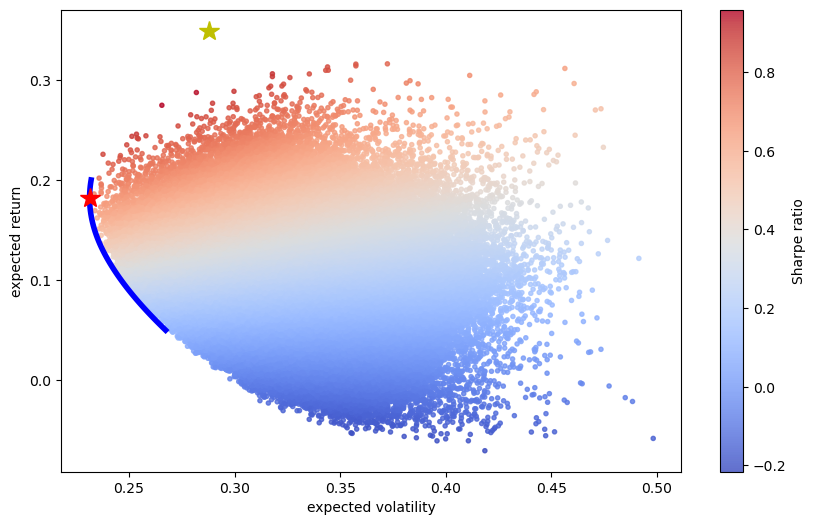

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(EV, ER, c=sharpe,marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvolatility, treturns, 'b', lw=4.0)
plt.plot(pV(sharpeOptimized['x']), pR(sharpeOptimized['x']),
         'y*', markersize=15.0)
plt.plot(pV(volOptimized['x']), pR(volOptimized['x']),
         'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')